| model        | overview | F1 score  | accuracy |
|--------------|----------|-----------|----------|
| CNN          | 256x256, 8_layers, 10_epochs |           |          |
| CNN          |          |           |          |
| CNN          |          |           |          |
| Resnet34     |          |           |          |
| Efficientnet |          |           |          |
| VGG16        |	


## Import library 

In [1]:
import random
import os
import gc

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import Adam
from torchsummary import summary
import torch.backends.cudnn as cudnn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from PIL import Image

import timm
from collections import Counter

c:\Users\morik\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
class CFG:
    def __init__(self):

        self.seed=777
        self.epochs=10
        self.batch_size=256
        self.learning_rate=0.0007
        self.input_class=None
        self.output_class=2
        self.img_size=256

        self.device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

        self.class_mapping = {
            "NORMAL":0,
            'PNEUMONIA':1,
        }
        

config=CFG()

def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

def torch_seed(seed=config.seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms=True
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    g = torch.Generator()
    g.manual_seed(seed)

torch_seed()

## Load data

## Train

In [3]:
def Load(dir):
    filepaths=[]
    labels=[]

    folds=os.listdir(dir)

    for fold in folds:
        foldpath=os.path.join(dir,fold)
        filelist=os.listdir(foldpath)
        for file in filelist:
            path=os.path.join(foldpath,file)
            filepaths.append(path)
            labels.append(fold)

    X=pd.Series(filepaths,name="filepaths")
    y=pd.Series(labels,name="labels")
    df=pd.concat([X,y],axis=1)

    return df

train_dir=".//train"
test_dir=".//test"
val_dir=".//val"

train_df=Load(train_dir)
test_df=Load(test_dir)
val_df=Load(val_dir)


In [4]:
train_df.head()

,filepaths,labels
0,.//train\NORMAL\IM-0115-0001.jpeg,NORMAL
1,.//train\NORMAL\IM-0117-0001.jpeg,NORMAL
2,.//train\NORMAL\IM-0119-0001.jpeg,NORMAL
3,.//train\NORMAL\IM-0122-0001.jpeg,NORMAL
4,.//train\NORMAL\IM-0125-0001.jpeg,NORMAL


In [5]:
test_df.head()

,filepaths,labels
0,.//test\NORMAL\IM-0001-0001.jpeg,NORMAL
1,.//test\NORMAL\IM-0003-0001.jpeg,NORMAL
2,.//test\NORMAL\IM-0005-0001.jpeg,NORMAL
3,.//test\NORMAL\IM-0006-0001.jpeg,NORMAL
4,.//test\NORMAL\IM-0007-0001.jpeg,NORMAL


In [6]:
val_df.head()

,filepaths,labels
0,.//val\NORMAL\NORMAL2-IM-1427-0001.jpeg,NORMAL
1,.//val\NORMAL\NORMAL2-IM-1430-0001.jpeg,NORMAL
2,.//val\NORMAL\NORMAL2-IM-1431-0001.jpeg,NORMAL
3,.//val\NORMAL\NORMAL2-IM-1436-0001.jpeg,NORMAL
4,.//val\NORMAL\NORMAL2-IM-1437-0001.jpeg,NORMAL


In [7]:
train_df["labels"].value_counts()

labels
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

# Show data

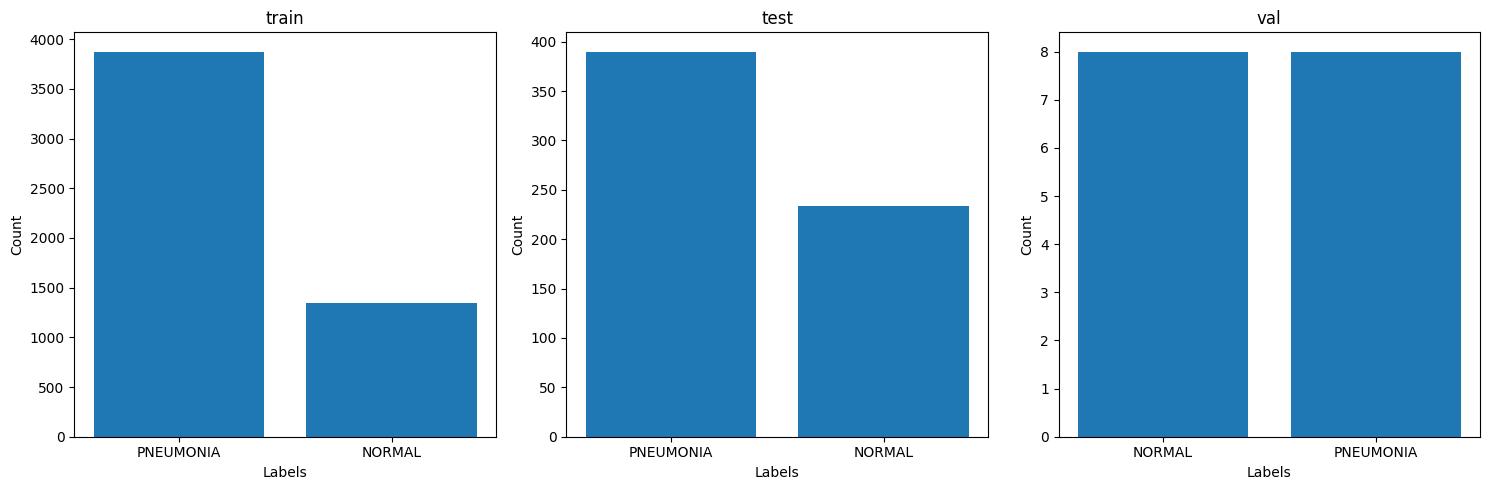

In [8]:
def Show(train_df,test_df,val_df):
    fig,axs=plt.subplots(1,3,figsize=(15,5))

    for i,(name,df) in enumerate(zip(["train","test","val"],[train_df,test_df,val_df])):
        label_counts=df["labels"].value_counts()
        axs[i].bar(label_counts.index,label_counts.values)
        axs[i].set_title(name)
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Count')
        axs[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

Show(train_df,test_df,val_df)

# Processing

In [9]:
# Normal -> 0 , Pneumonia -> 1
def encode(df):
    df["labels"]=df["labels"].map(config.class_mapping)

encode(train_df)
encode(test_df)
encode(val_df)

In [10]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
img_size=config.img_size

transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.RandomRotation(10), 
                                transforms.RandomHorizontalFlip(p=0.4), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean_nums, std=std_nums)
                                ])

test_transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean_nums, std=std_nums)
                                ])

# Transform Image

In [11]:
class ImageDataset(Dataset):

    def __init__(self,filepaths,labels,transform=None):
        self.filepaths=filepaths
        self.labels=labels
        self.transform=transform
    
    def __getitem__(self,index):
        torch_seed()
        img=Image.open(self.filepaths[index])
        if self.transform is not None:
            img=self.transform(img)
        label=self.labels[index]
        return img,label
    
    def __len__(self):
        return len(self.labels)


train_dataset=ImageDataset(train_df["filepaths"],train_df["labels"],transform)
test_dataset=ImageDataset(test_df["filepaths"],test_df["labels"],test_transform)

train,valid=train_test_split(train_dataset,test_size=0.2,random_state=777)

In [12]:
train_dataloader=DataLoader(train,batch_size=config.batch_size,worker_init_fn=worker_init_fn,shuffle=True)
valid_dataloader=DataLoader(valid,batch_size=config.batch_size,worker_init_fn=worker_init_fn,shuffle=True)
test_dataloader=DataLoader(test_dataset)

In [13]:
print(len(train))
print(len(valid))
print(len(test_dataset))

4172
1044
624


In [14]:
## save hyper parameters found by optuna
def save_params(name,params):
    file_name = f"{name}.txt"

    with open(file_name, 'w') as file:
        for key, value in params.items():
            file.write(f"{key}: {value}\n")

In [22]:
def save_model(name,model):
    file_name=f"{name}.pth"
    torch.save(model.state_dict(),file_name)

# CNN(8 layers)

In [15]:
class Model(nn.Module):

    def __init__(self,fc1_out):
        super().__init__()
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.dropout1=nn.Dropout(0.1)
        self.dropout2=nn.Dropout(0.2)
        
        self.conv1=nn.Conv2d(3,16,kernel_size=3)
        self.conv2=nn.Conv2d(16,32,kernel_size=3)
        self.conv3=nn.Conv2d(32,64,kernel_size=3)

        self.fc1=nn.Linear(64*30*30,fc1_out)
        self.fc2=nn.Linear(fc1_out,2)

    def forward(self,x):
        x=self.conv1(x)
        x-self.relu(x)
        x=self.pool(x)

        x=self.conv2(x)
        x=self.dropout1(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv3(x)
        x=self.dropout2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=x.view(x.size()[0],-1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        return x
    
CNN=Model(2048).to(config.device)
summary(CNN,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
           Dropout-5         [-1, 32, 125, 125]               0
              ReLU-6         [-1, 32, 125, 125]               0
         MaxPool2d-7           [-1, 32, 62, 62]               0
            Conv2d-8           [-1, 64, 60, 60]          18,496
           Dropout-9           [-1, 64, 60, 60]               0
             ReLU-10           [-1, 64, 60, 60]               0
        MaxPool2d-11           [-1, 64, 30, 30]               0
           Linear-12                 [-1, 2048]     117,966,848
             ReLU-13                 [-1, 2048]               0
           Linear-14                   

In [16]:
device=config.device

def train(model,optimizer,train_dataloader):
    torch_seed()
    criterion=nn.CrossEntropyLoss()
    loss_sum=0

    model.train()
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        pred=model(X)
        loss=criterion(pred,y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()
        count=Counter(y.cpu().numpy())
        print(count)

    train_loss=loss_sum/len(train_dataloader)

    return train_loss

def valid(model,valid_dataloader):
    torch_seed()
    criterion=nn.CrossEntropyLoss()
    loss_sum=0
    correct=0
    total=0

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in valid_dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            loss=criterion(pred,y)
            loss_sum+=loss.item()
            pred=pred.max(1, keepdim=True)[1]
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
            #count=Counter(y.cpu().numpy())
            #print(count)
    
    val_loss=loss_sum/len(valid_dataloader)
    val_acc=correct/total
    return val_loss,val_acc

def test(model,test_data):
    torch_seed()
    correct=0
    total=0
    y_true=[]
    y_pred=[]

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in test_data:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            pred=pred.max(1, keepdim=True)[1]
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    test_acc=correct/total
    return test_acc,cm,y_pred

## Find best hyper_param

In [17]:
def objective(trial):
    torch_seed()

    epochs=10
    fc1_out=trial.suggest_int('fc1_out',1024,2048)
    learning_rate=trial.suggest_float("learning_rate",0.00001,0.001)

    model=Model(fc1_out).to(device=config.device)
    optimizer=Adam(model.parameters(),lr=learning_rate)
    
    for epoch in range(epochs):
        loss=train(model,optimizer,train_dataloader)
        val_loss,val_acc=valid(model,valid_dataloader)
        print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    test_acc,_,__=test(model,test_dataloader)

    return test_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

cnn_params = study.best_params
print("Best Hyperparameters:", cnn_params)

save_params("cnn_best",cnn_params)

[I 2024-03-08 21:08:31,751] A new study created in memory with name: no-name-faffd3df-4041-44f9-b340-e8837c106ccf


Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 1.7135805698002087  val_loss : 0.4153126120567322  val_acc : 0.907088122605364 
Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 0.2289550045833868  val_loss : 0.1229053169488

[I 2024-03-08 21:09:11,477] Trial 0 finished with value: 0.8493589743589743 and parameters: {'fc1_out': 1042, 'learning_rate': 0.0008006339608817195}. Best is trial 0 with value: 0.8493589743589743.


Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 1.085022542406531  val_loss : 0.41905140280723574  val_acc : 0.8984674329501916 
Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 0.25653139677117853  val_loss : 0.14793538600

[I 2024-03-08 21:09:54,351] Trial 1 finished with value: 0.8573717948717948 and parameters: {'fc1_out': 1993, 'learning_rate': 0.0002895760498380433}. Best is trial 1 with value: 0.8573717948717948.


Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 2.025374279302709  val_loss : 0.4023473858833313  val_acc : 0.8467432950191571 
Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 0.2372117669266813  val_loss : 0.1532485052943

[I 2024-03-08 21:10:36,267] Trial 2 finished with value: 0.8525641025641025 and parameters: {'fc1_out': 1791, 'learning_rate': 0.0007379568039929328}. Best is trial 1 with value: 0.8573717948717948.


Best Hyperparameters: {'fc1_out': 1993, 'learning_rate': 0.0002895760498380433}


## Train, valid test

In [18]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.memory_allocated()

489140224

1993 0.0002895760498380433
Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 1.085022542406531  val_loss : 0.41905140280723574  val_acc : 0.8984674329501916 
Counter({1: 183, 0: 73})
Counter({1: 194, 0: 62})
Counter({1: 180, 0: 76})
Counter({1: 197, 0: 59})
Counter({1: 190, 0: 66})
Counter({1: 196, 0: 60})
Counter({1: 196, 0: 60})
Counter({1: 186, 0: 70})
Counter({1: 188, 0: 68})
Counter({1: 183, 0: 73})
Counter({1: 199, 0: 57})
Counter({1: 193, 0: 63})
Counter({1: 200, 0: 56})
Counter({1: 194, 0: 62})
Counter({1: 179, 0: 77})
Counter({1: 193, 0: 63})
Counter({1: 49, 0: 27})
train loss : 0.2565313967711785

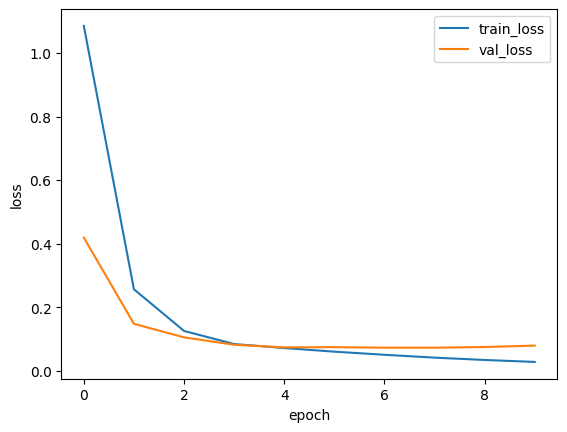

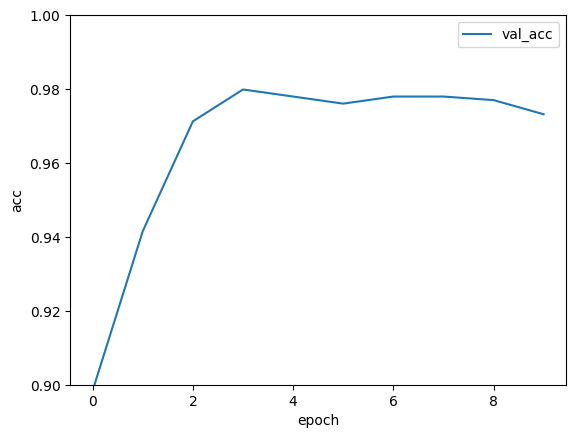

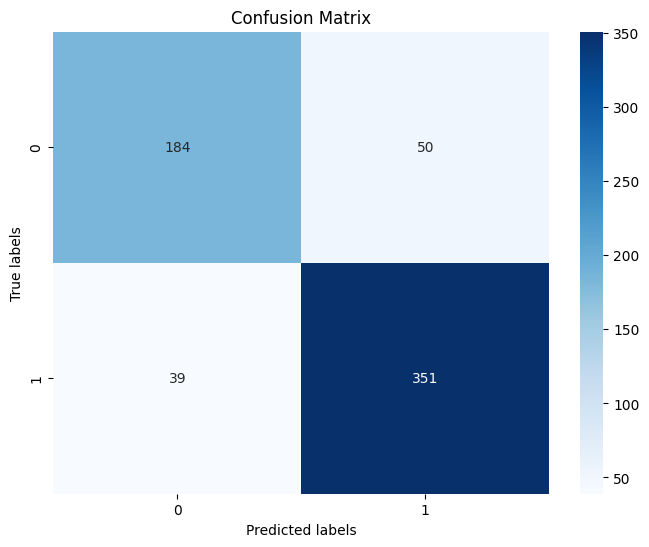

In [24]:
torch_seed()

loss_list=[]
val_loss_list=[]
val_acc_list=[]

epochs=10
fc1_out=cnn_params["fc1_out"]
learning_rate=cnn_params["learning_rate"]
print(fc1_out,learning_rate)

cnn_best=Model(fc1_out).to(device=config.device)
optimizer=Adam(cnn_best.parameters(),lr=learning_rate)

for epoch in range(epochs):
    loss=train(cnn_best,optimizer,train_dataloader)
    val_loss,val_acc=valid(cnn_best,valid_dataloader)
    print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

test_acc,cm,pred=test(cnn_best,test_dataloader)
print(test_acc)

save_model(f"cnn_best_{test_acc}",cnn_best)

plt.plot(loss_list,label="train_loss")
plt.plot(val_loss_list,label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.figure()
plt.plot(val_acc_list,label="val_acc")
plt.legend()
plt.ylim(0.9,1)
plt.xlabel("epoch")
plt.ylabel("acc")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Save csv

In [ ]:
final_output=pd.concat([pd.DataFrame(test_df["filepaths"]),pd.DataFrame(pred)],axis=1)
final_output.rename(columns={0:"labels"},inplace=True)

class_mapping_rev = {config.class_mapping[k] : k for k in config.class_mapping}

final_output['labels'] = final_output['labels'].map(class_mapping_rev)

final_output.to_csv('submission.csv', index=False)